# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
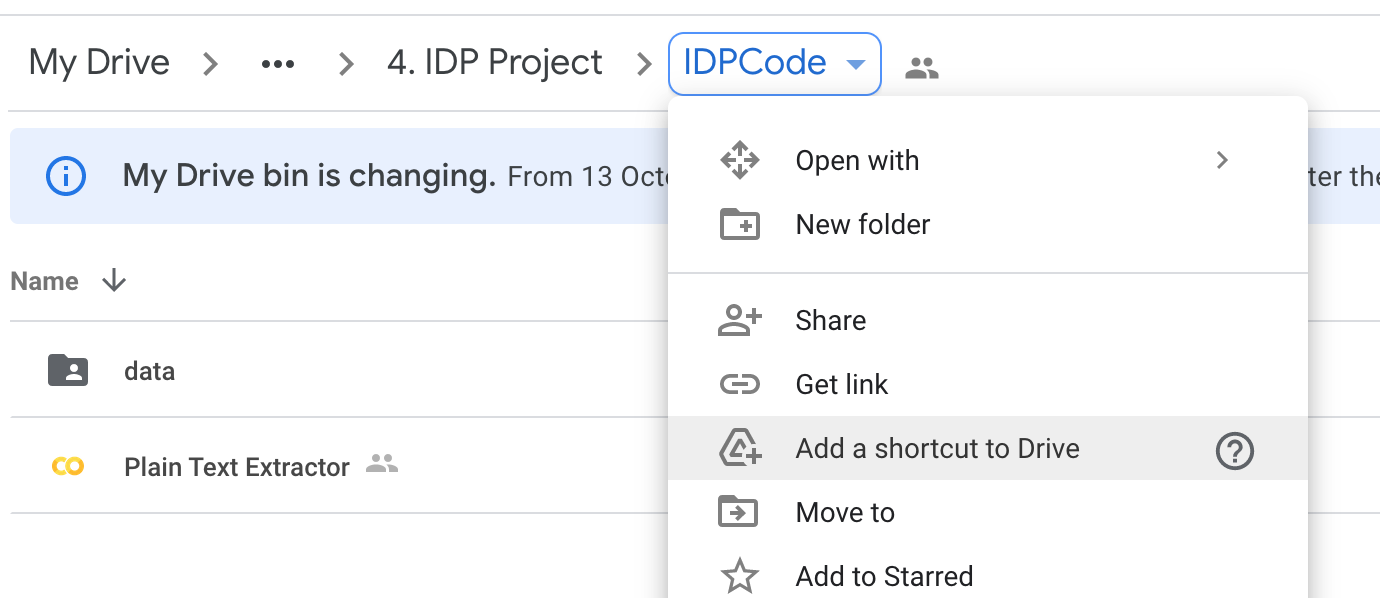
2. Run the command below to connect the GDrive:


In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1d2RlPHkcJvE2Q0NDVZjeNW8VcVz3h_WL/IDPCode


In [ ]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5
!pip install pyLDAvis

# Start from here if you run in local !!

In [ ]:
import pandas as pd
import numpy as np
import pickle5 as pickle

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='data'

time: 147 µs (started: 2021-04-08 20:29:17 +00:00)


# 1. Data pre-processing

In [ ]:
# Since Google Colab is not run in Python 3.8, we need to load dataframe with pickle5
#picklefile = open('dt_normalized_python36.pkl', 'rb')
#dt = pickle.load(picklefile)
#picklefile.close()




# dt = Dataset Tika
dt = pd.read_pickle('dt_normalized_python36.pkl') # https://drive.google.com/file/d/1THBPXX4wsHDQDDqImqaTkbGuc_VPzT2J/view?usp=sharing

time: 14.8 s (started: 2021-04-08 20:29:52 +00:00)


In [ ]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','', text)
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = text.replace('\n', ' ')
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
    
  return text

def lemmatizer(text):        
  sent = []
  doc = nlp(text)
  for word in doc:
    sent.append(word.lemma_)
    
  return " ".join(sent)

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1

  

time: 33 ms (started: 2021-04-08 20:30:06 +00:00)


## Accounting related stop words

In [ ]:
# Aaccounting related stop words
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une','company','new_york','summary','management','accounting_literature','journal_accounting_research','manager','study_focus','results','significant','show_table','understand','approach','figure','interpretation','paper','conference','target','literature','dollar','write','et_al','confirm','finds','accounting_review','tests','explore','analyze','two_reason_first','search']

time: 2.95 ms (started: 2021-04-08 20:30:06 +00:00)


## 1.4. Remove stop words

In [ ]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

# Remove stopwords
dt['content_accounting_stop_words'] = dt['content_stop_words'].apply(remove_stopwords)

time: 3.61 s (started: 2021-04-08 20:30:07 +00:00)


### Lemmatization

In [ ]:
import spacy
nlp = spacy.load('en')
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)
  
dt['content_lemmatized'] = dt['content_accounting_stop_words'].apply(lemmatizer)
dt['content_lemmatized_clean'] = dt['content_lemmatized'].str.replace('-PRON-', '')

time: 19min 42s (started: 2021-04-08 20:30:23 +00:00)


## 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)
  
dt['content_stemmed'] = dt['content_stop_words'].apply(stem_text)

time: 3min 31s (started: 2021-04-08 20:50:05 +00:00)


Difference between `dt['content'].head(1)` and `dt['content_stemmed'].head(1)`
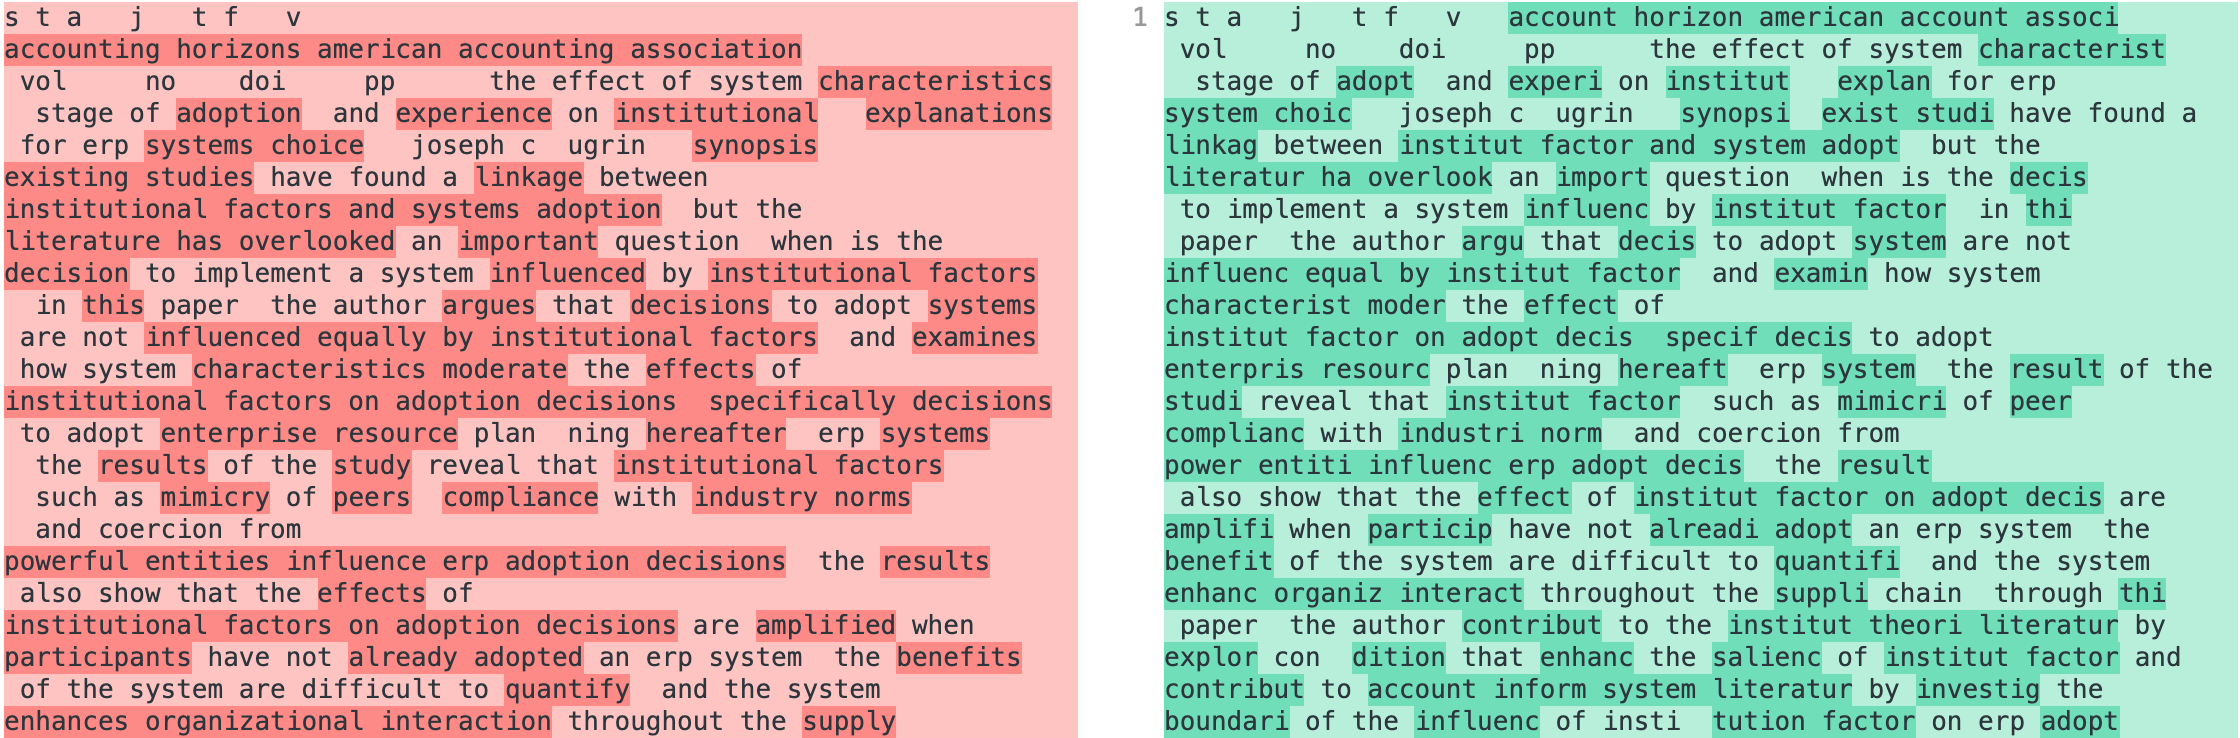

In [ ]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'total_page_count', 'content_stop_words', 'content_stemmed', 'content_lemmatized', 'content_lemmatized_clean'])

time: 6.5 ms (started: 2021-04-08 20:53:37 +00:00)


In [ ]:
dt3c.to_pickle('normalized_lemmatized.pkl')

time: 828 ms


In [ ]:
dt3c.head(1)

file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

   total_page_count  \
0                25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

time: 16.3 ms (started: 2021-04-08 20:20:21 +00:00)


In [ ]:
dt3c = pd.read_pickle('normalized_lemmatized.pkl')

time: 4.07 s


In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_lemmatized_clean']))

print(wordcloud)

time: 47 s (started: 2021-04-08 20:20:22 +00:00)


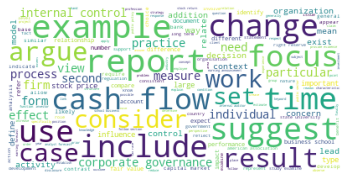

time: 142 ms (started: 2021-04-08 20:21:09 +00:00)


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

NUM_OF_TOPICS = 8
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 1.56 ms (started: 2021-04-08 21:00:25 +00:00)


## Unigrams

In [ ]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_lemmatized_clean'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

time: 14.5 s (started: 2021-04-08 20:21:09 +00:00)


## Bigrams

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_lemmatized_clean'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

time: 41.2 s (started: 2021-04-08 20:21:24 +00:00)


In [ ]:
# https://stackoverflow.com/questions/54139403/how-do-i-fix-debug-this-multi-process-terminated-worker-error-thrown-in-scikit-l#:~:text=TerminatedWorkerError%3A%20A%20worker%20process%20managed,System%20to%20kill%20the%20worker.
import scipy
scipy.test()

============================= test session starts ==============================
platform linux -- Python 3.7.10, pytest-3.6.4, py-1.10.0, pluggy-0.7.1
rootdir: /content/drive/.shortcut-targets-by-id/1d2RlPHkcJvE2Q0NDVZjeNW8VcVz3h_WL/IDPCode, inifile:
plugins: typeguard-2.7.1
collected 31852 items / 10954 deselected

scipy/_build_utils/tests/test_circular_imports.py .                      [  0%]
scipy/_build_utils/tests/test_scipy_version.py .                         [  0%]
scipy/_lib/tests/test__gcutils.py ......                                 [  0%]
scipy/_lib/tests/test__testutils.py ..                                   [  0%]
scipy/_lib/tests/test__threadsafety.py ..                                [  0%]
scipy/_lib/tests/test__util.py ....FFFFFFF.                              [  0%]
scipy/_lib/tests/test__version.py ........                               [  0%]
scipy/_lib/tests/test_ccallback.py ....                                  [  0%]
scipy/_lib/tests/test_import_cycles.py . 

In [ ]:
os.cpu_count()

# 2. Topic Modeling (LDA) CountVectorizer vs TFIDF Vectorizer

## 2.1. Count Vectorizer

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import os
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = count_vectorizer.fit_transform(dt3c['content_lemmatized_clean'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
  common_words                                    random_state=0,       
                                      # Multiple workers are not supported by Google Colab
                                      # so, we cannot user all available workers.
                                      # Default parameter of n_jobs in LatentDirichletAllocation is None.
                                      # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
                                      #n_jobs = -1 #os.cpu_count()  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
# For pyLDAvis, n_jobs is -1 as default. Since multiple workers are not supported
# by Google Colab, we should change it to 1.
# https://pyldavis.readthedocs.io/en/latest/modules/API.html
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne', n_jobs=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -108.958252 -208.941483       1        1  20.975823
6      186.487061  -98.103249       2        1  20.277953
7       19.245832  160.858780       3        1  12.865792
5      170.658829   75.445076       4        1  11.382296
0       -1.386411  -35.043739       5        1  10.838441
3     -145.800095  106.944611       6        1  10.355883
1       64.834541 -221.825272       7        1   9.770288
4     -196.906036  -58.990913       8        1   3.533524, topic_info=                  Term          Freq         Total Category  logprob  loglift
4752        university  50488.000000  50488.000000  Default  30.0000  30.0000
360            auditor  45196.000000  45196.000000  Default  29.0000  29.0000
1464           earning  48423.000000  48423.000000  Default  28.0000  28.0000
4513               tax  28788.000000  28788.000000  Default  27.0000  27.0000
1342        disclosure  28170.000000  28170.000000  Default  26.0000  26.0000
2522           journal  19779.000000  19779.000000  Default  25.0000  25.0000
3352       performance  28414.000000  28414.000000  Default  24.0000  24.0000
2409          internal  19269.000000  19269.000000  Default  23.0000  23.0000
773             client  14474.000000  14474.000000  Default  22.0000  22.0000
4300          standard  19637.000000  19637.000000  Default  21.0000  21.0000
1062              cost  32860.000000  32860.000000  Default  20.0000  20.0000
1047         corporate  22921.000000  22921.000000  Default  19.0000  19.0000
3850            report  45526.000000  45526.000000  Default  18.0000  18.0000
200            analyst  19027.000000  19027.000000  Default  17.0000  17.0000
1873          forecast  16695.000000  16695.000000  Default  16.0000  16.0000
2271            income  14262.000000  14262.000000  Default  15.0000  15.0000
3657           quality  25067.000000  25067.000000  Default  14.0000  14.0000
4341             stock  22657.000000  22657.000000  Default  13.0000  13.0000
359           auditing  15908.000000  15908.000000  Default  12.0000  12.0000
2010        governance  13162.000000  13162.000000  Default  11.0000  11.0000
3523             price  21861.000000  21861.000000  Default  10.0000  10.0000
371             author  16080.000000  16080.000000  Default   9.0000   9.0000
1803               fee  10291.000000  10291.000000  Default   8.0000   8.0000
3907            return  19627.000000  19627.000000  Default   7.0000   7.0000
2448          investor  23808.000000  23808.000000  Default   6.0000   6.0000
625            capital  19987.000000  19987.000000  Default   5.0000   5.0000
2825            market  42331.000000  42331.000000  Default   4.0000   4.0000
3703              rate  12596.000000  12596.000000  Default   3.0000   3.0000
4312         statement  15367.000000  15367.000000  Default   2.0000   2.0000
4036            school  13484.000000  13484.000000  Default   1.0000   1.0000
1115               csr   2589.528607   2590.447227   Topic1  -6.4709   1.5614
1348         discourse   1741.469653   1742.387729   Topic1  -6.8677   1.5613
3215    organisational   3201.348552   3203.251268   Topic1  -6.2588   1.5612
1629               erp   1037.582674   1038.501454   Topic1  -7.3855   1.5609
2617          laughlin    773.980700    774.899145   Topic1  -7.6786   1.5606
2053           guthrie    772.437351    773.356698   Topic1  -7.6806   1.5606
152                ais    672.987420    673.906530   Topic1  -7.8184   1.5604
4220         sociology    624.628388    625.569303   Topic1  -7.8930   1.5603
627         capitalism    689.800418    690.883681   Topic1  -7.7938   1.5602
3824         religious    575.829103    576.747353   Topic1  -7.9744   1.5602
4022           scapens    550.752343    551.671236   Topic1  -8.0189   1.5601
442         bebbington    546.555080    547.473387   Topic1  -8.0265   1.5601
3214      organisation 

time: 2min 3s (started: 2021-04-08 21:07:11 +00:00)


In [ ]:
import os
print("# of cpus: " + str(os.cpu_count()))

# of cpus: 2
time: 2.05 ms (started: 2021-04-08 21:15:56 +00:00)


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,auditor,internal,client,quality,auditing,report,fee,risk,control,committee,fraud,study,big,provide,independence,service,section,sox,public,evidence
Topic 1,tax,cost,income,rate,capital,investment,asset,government,model,effect,policy,increase,public,dividend,revenue,market,taxis,benefit,value,price
Topic 2,social,study,practice,change,process,business,new,public,environmental,work,theory,organization,issue,accountability,role,provide,control,development,perspective,sector
Topic 3,report,standard,statement,international,country,company,reporting,issue,ifrs,provide,regulation,set,base,user,rule,study,require,value,fair,use
Topic 4,university,journal,author,school,article,review,include,editor,business,publish,publication,new,australia,finance,manuscript,professor,association,paper,table,pour
Topic 5,disclosure,corporate,governance,firm,bank,study,risk,shareholder,board,market,quality,report,cost,capital,debt,high,company,private,increase,investor
Topic 6,earning,market,stock,analyst,value,price,return,forecast,investor,model,accrual,university,study,future,cash,firm,evidence,period,measure,risk
Topic 7,performance,decision,study,measure,manager,use,control,effect,model,base,incentive,compensation,cost,level,provide,firm,risk,process,university,task


time: 48.3 ms (started: 2021-04-08 21:16:06 +00:00)


## 2.2. Term Frequency–Inverse Document Frequency (TF-IDF) Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words = stop_list,
                             ngram_range = (1,1))
doc_word = vectorizer.fit_transform(dt['content_lemmatized_clean'])

time: 6.41 s (started: 2021-04-08 21:16:10 +00:00)


In [ ]:
vectorizer.get_feature_names()[0:5]

['aa', 'aaa', 'aaaan', 'aaahorsubm', 'aaahq']

time: 126 ms (started: 2021-04-08 21:16:17 +00:00)


In [ ]:
lda_model_tfidf = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      # Multiple workers are not supported by Google Colab
                                      # so, we cannot user all available workers.
                                      # Default parameter of n_jobs in LatentDirichletAllocation is None.
                                      # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
                                      #n_jobs = -1 #os.cpu_count()  # Use all available CPUs
                                     )
lda_output_tfidf = lda_model_tfidf.fit_transform(doc_word)

time: 1min 11s (started: 2021-04-08 21:16:35 +00:00)


In [ ]:
pyLDAvis.enable_notebook()
# For pyLDAvis, n_jobs is -1 as default. Since multiple workers are not supported
# by Google Colab, we should change it to 1.
# https://pyldavis.readthedocs.io/en/latest/modules/API.html
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_word, vectorizer, mds='tsne', n_jobs=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -108.958252 -208.941483       1        1  91.342442
2      186.487061  -98.103249       2        1   2.303366
5       19.245832  160.858780       3        1   1.069122
6      170.658829   75.445076       4        1   1.064345
7       -1.386411  -35.043739       5        1   1.060560
3     -145.800095  106.944611       6        1   1.059983
0       64.834541 -221.825272       7        1   1.050721
4     -196.906036  -58.990913       8        1   1.049462, topic_info=                         Term        Freq       Total Category  logprob  \
7944                  auditor  332.000000  332.000000  Default  30.0000   
31771                 earning  311.000000  311.000000  Default  29.0000   
83964                    pour    3.000000    3.000000  Default  28.0000   
93903                 rsultat    2.000000    2.000000  Default  27.0000   
100716                   sont    2.000000    2.000000  Default  26.0000   
17097                     ces    2.000000    2.000000  Default  25.0000   
62121                    leur    2.000000    2.000000  Default  24.0000   
8182                   auteur    2.000000    2.000000  Default  23.0000   
103401                  study  229.000000  229.000000  Default  22.0000   
116473            vrification    2.000000    2.000000  Default  21.0000   
63037            linformation    1.000000    1.000000  Default  20.0000   
106033                    tax  222.000000  222.000000  Default  19.0000   
66385                  market  218.000000  218.000000  Default  18.0000   
90911                  report  217.000000  217.000000  Default  17.0000   
28945              disclosure  216.000000  216.000000  Default  16.0000   
77532                     ont    1.000000    1.000000  Default  15.0000   
100361                  socit    1.000000    1.000000  Default  14.0000   
116471            vrificateur    1.000000    1.000000  Default  13.0000   
113181             university  199.000000  199.000000  Default  12.0000   
92652                    risk  195.000000  195.000000  Default  11.0000   
15114                   cadre    1.000000    1.000000  Default  10.0000   
17148                   cette    1.000000    1.000000  Default   9.0000   
92721                  risque    1.000000    1.000000  Default   8.0000   
50767                     ils    1.000000    1.000000  Default   7.0000   
97059                   selon    1.000000    1.000000  Default   6.0000   
114550                 valeur    1.000000    1.000000  Default   5.0000   
22816                    cost  179.000000  179.000000  Default   4.0000   
81282             performance  179.000000  179.000000  Default   3.0000   
105783                   tant    6.000000    6.000000  Default   2.0000   
932                    accrue    6.000000    6.000000  Default   1.0000   
7944                  auditor  332.401071  332.489737   Topic1  -5.8548   
31771                 earning  311.628923  311.717589   Topic1  -5.9193   
103401                  study  229.009296  229.097960   Topic1  -6.2273   
106033                    tax  222.609645  222.698312   Topic1  -6.2557   
66385                  market  218.291428  218.380092   Topic1  -6.2753   
90911                  report  217.585160  217.673825   Topic1  -6.2785   
28945              disclosure  216.418179  216.506843   Topic1  -6.2839   
113181             university  199.730061  199.818730   Topic1  -6.3641   
92652                    risk  195.791436  195.880101   Topic1  -6.3841   
22816                    cost  179.793222  179.881887   Topic1  -6.4693   
81282             performance  179.388175  179.476843   Topic1  -6.4716   
114648                  value  176.662648  176.751313   Topic1  -6.4869   
22172                 control  170.446609  170.535273   Topic1  -6.5227   
87216                 quality  165.594048  165.682713   Topic1  -6.5516   
39

time: 6.46 s (started: 2021-04-08 21:17:47 +00:00)
